In [1]:

import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


/Users/sumaiyauddin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
# Define the paths to your image and annotation folders
path_image = "../data/external/Coral_images/image02"
path_annotations = "../data/external/Coral_images/annotation"

# Initialize lists to store images, labels, and masks
images = []
labels = []
masks = []

# Common image size (e.g., 224x224)
common_image_size = (224, 224)

# Iterate through each XML file in the annotation folder
for xml_filename in os.listdir(path_annotations):
    if xml_filename.lower().endswith(".xml"):
        xml_path = os.path.join(path_annotations, xml_filename)

        # Extract the corresponding image filename
        image_filename = xml_filename.replace(".xml", ".jpg")
        image_path = os.path.join(path_image, image_filename)

        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Image not found for XML: {xml_filename}")
            continue

        # Parse the XML file to extract the label and bounding box coordinates
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Initialize a mask for the original-sized image
        original_image = cv2.imread(image_path)
        original_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)

        for object_elem in root.findall("object"):
            name_elem = object_elem.find("name")
            bndbox_elem = object_elem.find("bndbox")

            if name_elem is not None and bndbox_elem is not None:
                label = name_elem.text
                xmin = int(bndbox_elem.find("xmin").text)
                ymin = int(bndbox_elem.find("ymin").text)
                xmax = int(bndbox_elem.find("xmax").text)
                ymax = int(bndbox_elem.find("ymax").text)

                # Create a binary mask using the bounding box coordinates
                object_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
                object_mask[ymin:ymax, xmin:xmax] = 1

                # Add the object mask to the composite mask
                original_mask = np.maximum(original_mask, object_mask)

        # Resize the original-sized image and mask to the common size
        image = cv2.resize(original_image, common_image_size)
        mask = cv2.resize(original_mask, common_image_size)

        # Append the resized image and label to the lists
        images.append(image)
        labels.append(label)

        # Append the resized mask to the masks list
        masks.append(mask)

# Convert the lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

# Now, you have NumPy arrays for the resized images, masks, and labels
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Labels shape: {labels.shape}")
# Check class distribution
unique_labels, class_counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, class_counts):
    print(f"Class: {label}, Count: {count}")


Images shape: (899, 224, 224, 3)
Masks shape: (899, 224, 224)
Labels shape: (899,)
Class: APAL, Count: 113
Class: Pseudodiploria, Count: 786


In [25]:
# Filter images and labels for the "apal" class
apal_images = images[labels == "APAL"]
apal_labels = labels[labels == "APAL"]
apal_masks = masks[labels == "APAL"]
# Check the shape of the filtered data
print(f"Filtered APAL Images shape: {apal_images.shape}")
print(f"Filtered APAL Labels shape: {apal_labels.shape}")
print(f"Filtered APAL Labels shape: {apal_masks.shape}")

Filtered APAL Images shape: (113, 224, 224, 3)
Filtered APAL Labels shape: (113,)
Filtered APAL Labels shape: (113, 224, 224)


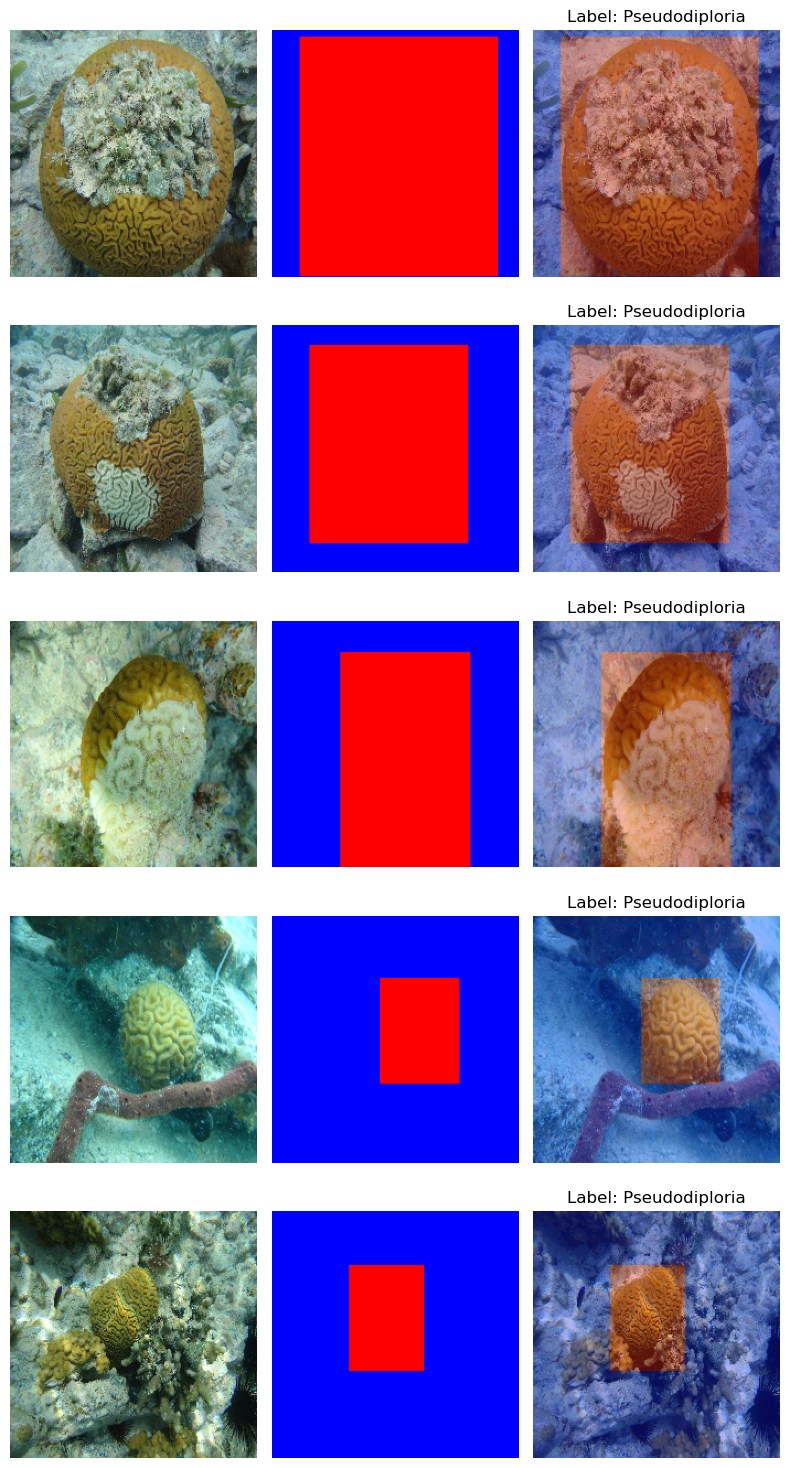

In [26]:
# Number of image-mask pairs to display
num_pairs_to_display = 5

# Create a figure with subplots
fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    mask = masks[i]
    label = labels[i]

    # Create a blue mask for the back part
    blue_mask = (mask == 0).astype(np.uint8) * 255

    # Create a red mask for the white part
    red_mask = (mask != 0).astype(np.uint8) * 255

    # Create a new image with blue and red regions based on the masks
    combined_mask = np.zeros_like(image)
    combined_mask[:, :, 0] = red_mask  # Set the red channel to red_mask
    combined_mask[:, :, 2] = blue_mask  # Set the blue channel to blue_mask

    # Overlay the combined mask on top of the original image
    overlay_image = cv2.addWeighted(image, 0.7, combined_mask, 0.3, 0)

    # Plot the original image
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')

    # Plot the modified mask with blue and red parts
    axes[i, 1].imshow(combined_mask)
    axes[i, 1].axis('off')

    # Plot the overlay image
    axes[i, 2].imshow(overlay_image)
    axes[i, 2].set_title(f"Label: {label}")
    axes[i, 2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [27]:
# Save the apal images to a pickle file
with open('images.pkl', 'wb') as file:
    pickle.dump(apal_images, file)

# Save the apal masks to a pickle file
with open('masks.pkl', 'wb') as file:
    pickle.dump(apal_masks, file)
    
# Save the apal labels to a pickle file
with open('labels.pkl', 'wb') as file:
    pickle.dump(apal_labels, file)


In [28]:


# Define the filenames for the pickle files
images2 = 'augmented_apal_images.pickle'
labels2 = 'augmented_apal_labels.pickle'
masks2 = 'augmented_apal_masks.pickle'

# Load the augmented images from the pickle file
with open(images2, 'rb') as file:
    images2 = pickle.load(file)

# Load the augmented labels from the pickle file
with open(labels2, 'rb') as file:
    labels2 = pickle.load(file)

# Load the augmented masks from the pickle file
with open(masks2, 'rb') as file:
    masks2 = pickle.load(file)
    
print("Loaded Images Shape:", images2.shape)
print("Loaded Labels Shape:", labels2.shape)
print("Loaded Masks Shape:", masks2.shape)




Loaded Images Shape: (565, 224, 224, 3)
Loaded Labels Shape: (565,)
Loaded Masks Shape: (565, 224, 224)


In [29]:
# Concatenate the loaded data
images = np.concatenate((images, images2), axis=0)
labels = np.concatenate((labels, labels2), axis=0)
masks = np.concatenate((masks, masks2), axis=0)

# Print the shape of the concatenated arrays
print("Concatenated Images Shape:", images.shape)
print("Concatenated Labels Shape:", labels.shape)
print("Concatenated Masks Shape:", masks.shape)


# Check class distribution
unique_labels, class_counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, class_counts):
    print(f"Class: {label}, Count: {count}")


Concatenated Images Shape: (1464, 224, 224, 3)
Concatenated Labels Shape: (1464,)
Concatenated Masks Shape: (1464, 224, 224)
Class: APAL, Count: 678
Class: Pseudodiploria, Count: 786


## Splitting for classification

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (936, 224, 224, 3)
y_train shape: (936,)
X_valid shape: (235, 224, 224, 3)
y_valid shape: (235,)
X_test shape: (293, 224, 224, 3)
y_test shape: (293,)


In [42]:
# Save your data to a pickle file
with open('../data/external/data_vgg16.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test, X_valid, y_valid), f)

## Splitting for segmentation

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (936, 224, 224, 3)
y_train shape: (936, 224, 224)
X_valid shape: (235, 224, 224, 3)
y_valid shape: (235, 224, 224)
X_test shape: (293, 224, 224, 3)
y_test shape: (293, 224, 224)


In [31]:
# Save your data to a pickle file
with open('../data/external/data_mask.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test, X_valid, y_valid), f)

### YOLO loading

In [18]:
# Reading annotation txt file that has bounding boxes coordinates in YOLO format
with open('../data/external/Coral_images/yolo/APAL01.txt') as f:
    # Preparing list for annotation of BB (bounding boxes)
    lst = []
    for line in f:
        lst += [line.rstrip()]
        print(line)

# Going through all BB
for i in range(len(lst)):
    # Getting current bounding box coordinates, its width and height
    bb_current = lst[i].split()
    x_center, y_center = int(float(bb_current[1]) * w), int(float(bb_current[2]) * h)
    box_width, box_height = int(float(bb_current[3]) * w), int(float(bb_current[4]) * h)
    
    # Now, from YOLO data format, we can get top left corner coordinates
    # that are x_min and y_min
    x_min = int(x_center - (box_width / 2))
    y_min = int(y_center - (box_height / 2))

    # Drawing bounding box on the original image
    cv2.rectangle(image_BGR, (x_min, y_min), (x_min + box_width, y_min + box_height), [0 , 0, 255], 2)
    # Preparing text with label and confidence for current bounding box
    class_current = 'Class: {}'.format(bb_current[0])

    # Putting text with label and confidence on the original image
    cv2.putText(image_BGR, class_current, (x_min, y_min - 5), cv2.FONT_HERSHEY_COMPLEX, 1, [0 , 0, 255], 2)


APAL 0.492 0.554 0.735 0.315

APAL 0.156 0.877 0.309 0.220

APAL 0.057 0.679 0.111 0.141


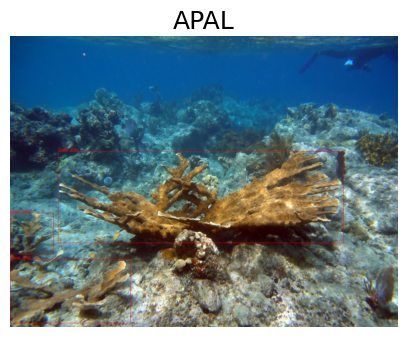

In [19]:
%matplotlib inline

# Plotting this example
# Setting default size of the plot
plt.rcParams['figure.figsize'] = (5, 5)

# Initializing the plot
fig = plt.figure()

plt.imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('APAL', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('example.png')
plt.close()

### Yolo formate resizng images

In [31]:
import os
import cv2
import numpy as np

# Paths
image_folder = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/image02"
annotation_folder = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/yolo"

# Resize dimensions
resize_width, resize_height = 224, 224

# Lists to store images and labels
images = []
all_labels = []

# Read images and annotations
for file_name in os.listdir(image_folder):
    if file_name.endswith(".jpg") or file_name.endswith(".JPG"):
        # Image path
        image_path = os.path.join(image_folder, file_name)

        # YOLO annotation path
        annotation_path = os.path.join(annotation_folder, file_name.replace(".jpg", ".txt").replace(".JPG", ".txt"))

        # Check if YOLO annotation file exists
        if not os.path.exists(annotation_path):
            print(f"Skipping image {file_name} because no YOLO annotation file found.")
            continue

        # Read image
        img = cv2.imread(image_path)
        original_image_width, original_image_height = img.shape[1], img.shape[0]  # Get original image size
        img = cv2.resize(img, (resize_width, resize_height))
        images.append(img)

        # Read YOLO annotation
        with open(annotation_path, 'r') as file:
            lines = file.readlines()

            # Extracting all bounding boxes from YOLO annotation
            bounding_boxes = []
            for line in lines:
                label_parts = line.strip().split()
                class_label = label_parts[0]
                center_x, center_y, width, height = map(float, label_parts[1:])
                
                # # Normalize the coordinates based on the original image size
                # X = center_x / original_image_width
                # Y = center_y / original_image_height
                # width1 = width / original_image_width
                # height1 = height / original_image_height

                # # Scale the coordinates based on the new resized image size
                # x = X * resize_width
                # y = Y * resize_height
                # width = width1 * resize_width
                # height = height1 * resize_height
                x = center_x 
                y = center_y 
                width1 = width 
                height1 = height 

                bounding_boxes.append({
                    'class_label': class_label,
                    'x': x,
                    'y': y,
                    'width': width,
                    'height': height
                })

            all_labels.append(bounding_boxes)

# Convert lists to numpy arrays
images_array = np.array(images)
labels_array = np.array(all_labels, dtype=object)

# Display the shapes
print("Images array shape:", images_array.shape)
print("Labels array shape:", labels_array.shape)


Skipping image Pseudodiploria181.JPG because no YOLO annotation file found.
Skipping image Pseudodiploria584.JPG because no YOLO annotation file found.
Skipping image Pseudodiploria45.JPG because no YOLO annotation file found.
Skipping image Pseudodiploria718.JPG because no YOLO annotation file found.
Skipping image APAL76.jpg because no YOLO annotation file found.
Skipping image APAL100.jpg because no YOLO annotation file found.
Skipping image Pseudodiploria284.JPG because no YOLO annotation file found.
Skipping image Pseudodiploria788.jpg because no YOLO annotation file found.
Skipping image APAL36.jpg because no YOLO annotation file found.
Images array shape: (899, 224, 224, 3)
Labels array shape: (899,)


In [41]:
from collections import defaultdict

# Dictionary to store the count of images for each class
class_count = defaultdict(int)

# Iterate through the labels_array
for labels in labels_array:
    unique_classes = set(box['class_label'] for box in labels)
    for class_label in unique_classes:
        class_count[class_label] += 1

# Print the count for each class
for class_label, count in class_count.items():
    print(f"Class {class_label}: {count} images")


Class Pseudodiploria: 786 images
Class APAL: 116 images


In [32]:
# Print the first three values in labels_array
print("First values in labels_array:", labels_array[200])

First values in labels_array: [{'class_label': 'APAL', 'x': 0.492, 'y': 0.554, 'width': 0.735, 'height': 0.315}, {'class_label': 'APAL', 'x': 0.156, 'y': 0.877, 'width': 0.309, 'height': 0.22}, {'class_label': 'APAL', 'x': 0.057, 'y': 0.679, 'width': 0.111, 'height': 0.141}]


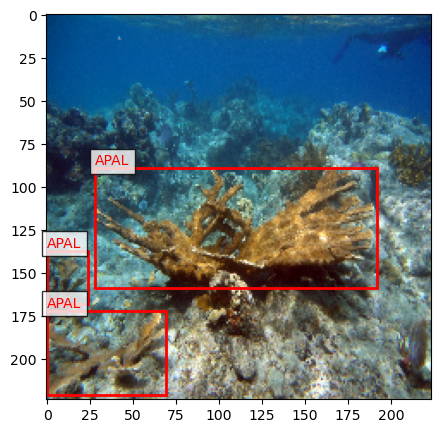

In [36]:
# Choose an index to visualize
index_to_visualize = 200

# Get the image and label for the chosen index
image_to_visualize = images_array[index_to_visualize]
labels_to_visualize = labels_array[index_to_visualize]

# Display the image
plt.imshow(cv2.cvtColor(image_to_visualize, cv2.COLOR_BGR2RGB))

# Iterate through bounding boxes in YOLO format
for box in labels_to_visualize:
    class_label = box['class_label']
    center_x, center_y, width, height = box['x'], box['y'], box['width'], box['height']

    # Rescale the coordinates based on the original image size
    x = int(center_x * original_image_width)
    y = int(center_y * original_image_height)
    w = int(width * original_image_width)
    h = int(height * original_image_height)

    # Calculate top-left coordinates
    x_min = max(0, x - w // 2)
    y_min = max(0, y - h // 2)

    # Create a Rectangle patch
    bbox = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='r', facecolor='none')

    # Add the bbox to the plot
    plt.gca().add_patch(bbox)

    # Add class label to the plot
    plt.text(x_min, y_min, class_label, color='r', verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# Display the plot
plt.show()


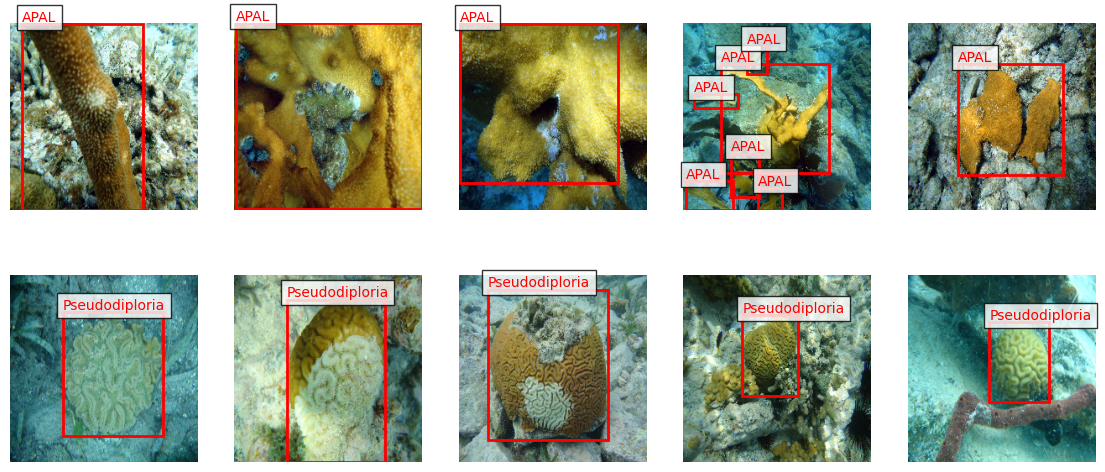

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose the classes to visualize
classes_to_visualize = ['APAL', 'Pseudodiploria']

# Counter to keep track of displayed images for each class
displayed_images_count = {'APAL': 0, 'Pseudodiploria': 0}

# Create a subplot with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

# Iterate through images and display up to 5 images for each class
for i, labels in enumerate(labels_array):
    # Check if the image contains any of the classes to visualize
    if any(box['class_label'] in classes_to_visualize for box in labels):
        # Get the unique class labels for the current image
        unique_class_labels = set(box['class_label'] for box in labels)

        # Iterate through unique class labels and display images
        for class_label in unique_class_labels:
            if class_label in classes_to_visualize and displayed_images_count[class_label] < 5:
                # Get the image
                image = images_array[i]

                # Display the image
                axs[classes_to_visualize.index(class_label), displayed_images_count[class_label]].imshow(
                    cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                )

                # Iterate through bounding boxes of the current class and display
                for box in labels:
                    if box['class_label'] == class_label:
                        center_x, center_y, width, height = box['x'], box['y'], box['width'], box['height']
                        x = int(center_x * original_image_width)
                        y = int(center_y * original_image_height)
                        w = int(width * original_image_width)
                        h = int(height * original_image_height)
                        x_min = max(0, x - w // 2)
                        y_min = max(0, y - h // 2)

                        # Display the bounding box
                        bbox = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='r', facecolor='none')
                        axs[classes_to_visualize.index(class_label), displayed_images_count[class_label]].add_patch(bbox)
                        axs[classes_to_visualize.index(class_label), displayed_images_count[class_label]].text(
                            x_min, y_min, class_label, color='r', verticalalignment='bottom',
                            bbox=dict(facecolor='white', alpha=0.8)
                        )

                # Update the displayed images count
                displayed_images_count[class_label] += 1

# Remove empty subplots
for i in range(2):
    for j in range(5):
        axs[i, j].axis('off')

# Show the plot
plt.show()


In [60]:
unique_classes = set(class_label for labels in labels_array for box in labels for class_label in [box['class_label']])
print("Unique Classes:", unique_classes)


Unique Classes: {'Pseudodiploria', 'APAL'}


In [61]:
# Filter images and labels for the "APAL" class
filtered_images_apal = images_array[[
    any(box['class_label'] == 'APAL' for box in labels) for labels in labels_array
]]
filtered_labels_apal = labels_array[
    [any(box['class_label'] == 'APAL' for box in labels) for labels in labels_array]
]

# Display the shapes
print("Filtered Images shape for class APAL:", filtered_images_apal.shape)
print("Filtered Labels shape for class APAL:", filtered_labels_apal.shape)


Filtered Images shape for class APAL: (116, 224, 224, 3)
Filtered Labels shape for class APAL: (116,)


In [64]:
# Save the apal images to a pickle file
with open('images_yolo.pkl', 'wb') as file:
    pickle.dump(filtered_images_apal, file)

    
# Save the apal labels to a pickle file
with open('labels_yolo.pkl', 'wb') as file:
    pickle.dump(filtered_labels_apal, file)


In [65]:
# Define the filenames for the pickle files
images2 = 'augmented_apal_images_yolo.pickle'
labels2 = 'augmented_apal_labels_yolo.pickle'


# Load the augmented images from the pickle file
with open(images2, 'rb') as file:
    images2 = pickle.load(file)

# Load the augmented labels from the pickle file
with open(labels2, 'rb') as file:
    labels2 = pickle.load(file)

print("Loaded Images Shape:", images2.shape)
print("Loaded Labels Shape:", labels2.shape)


Loaded Images Shape: (580, 224, 224, 3)
Loaded Labels Shape: (580,)


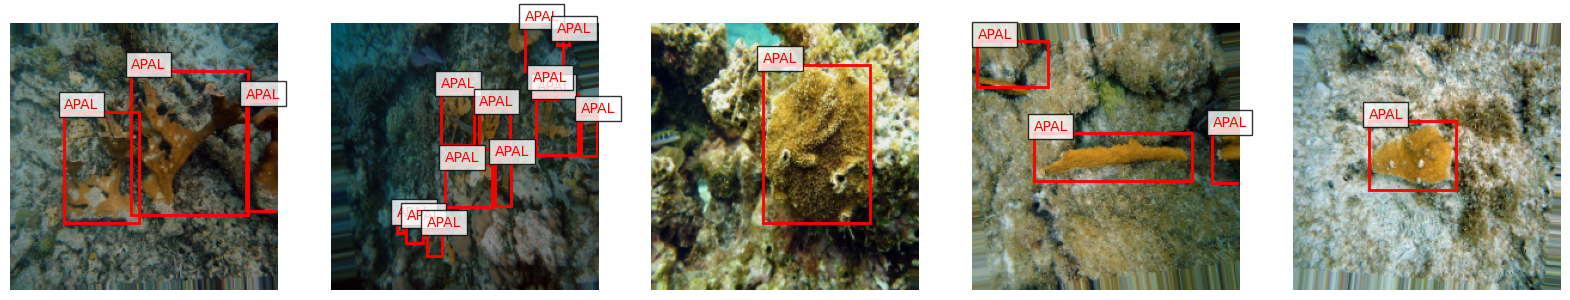

In [72]:
import random

# Choose 5 random indices
random_indices = random.sample(range(len(images2)), 5)

# Create a subplot with 1 row and 5 columns
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Iterate through the randomly chosen indices
for i, index in enumerate(random_indices):
    # Get the image and labels for the current index
    image_to_visualize = images2[index]
    labels_to_visualize = labels2[index]

    # Flip the image to ensure correct color channel order
    image_to_visualize_flipped = np.flip(image_to_visualize, axis=-1)

    # Normalize pixel values
    image_to_visualize_flipped = image_to_visualize_flipped / 255.0

    # Display the image with the 'gray' colormap
    axs[i].imshow(image_to_visualize_flipped, cmap='gray')

    # Iterate through bounding boxes in YOLO format
    for box in labels_to_visualize:
        class_label = box['class_label']
        center_x, center_y, width, height = box['x'], box['y'], box['width'], box['height']

        # Rescale the coordinates based on the original image size
        x = int(center_x * original_image_width)
        y = int(center_y * original_image_height)
        w = int(width * original_image_width)
        h = int(height * original_image_height)

        # Calculate top-left coordinates
        x_min = max(0, x - w // 2)
        y_min = max(0, y - h // 2)

        # Create a Rectangle patch
        bbox = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='r', facecolor='none')

        # Add the bbox to the plot
        axs[i].add_patch(bbox)

        # Add class label to the plot
        axs[i].text(x_min, y_min, class_label, color='r', verticalalignment='bottom',
                    bbox=dict(facecolor='white', alpha=0.8))

    # Remove axes for better visualization
    axs[i].axis('off')

# Display the plot
plt.show()


In [73]:
# Concatenate the loaded data
images = np.concatenate((images_array, images2), axis=0)
labels = np.concatenate((labels_array, labels2), axis=0)

# Print the shape of the concatenated arrays
print("Concatenated Images Shape:", images.shape)
print("Concatenated Labels Shape:", labels.shape)


Concatenated Images Shape: (1479, 224, 224, 3)
Concatenated Labels Shape: (1479,)


In [74]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (946, 224, 224, 3)
y_train shape: (946,)
X_valid shape: (237, 224, 224, 3)
y_valid shape: (237,)
X_test shape: (296, 224, 224, 3)
y_test shape: (296,)


In [75]:
# Save your data to a pickle file
with open('../data/external/data_yolo.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test, X_valid, y_valid), f)

## Yolo loading with new formate

In [3]:
import os
import cv2
import numpy as np

# Paths
image_folder = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/image02"
annotation_folder = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/yolo"

# Resize dimensions
resize_width, resize_height = 224, 224

# Lists to store images and labels
images = []
all_labels = []

# Read images and annotations
for file_name in os.listdir(image_folder):
    if file_name.endswith(".jpg") or file_name.endswith(".JPG"):
        # Image path
        image_path = os.path.join(image_folder, file_name)

        # YOLO annotation path
        annotation_path = os.path.join(annotation_folder, file_name.replace(".jpg", ".txt").replace(".JPG", ".txt"))

        # Check if YOLO annotation file exists
        if not os.path.exists(annotation_path):
            print(f"Skipping image {file_name} because no YOLO annotation file found.")
            continue

        # Read image
        img = cv2.imread(image_path)
        original_image_width, original_image_height = img.shape[1], img.shape[0]  # Get original image size
        img = cv2.resize(img, (resize_width, resize_height))
        images.append(img)

        # Read YOLO annotation
        with open(annotation_path, 'r') as file:
            lines = file.readlines()

            # Extracting all bounding boxes from YOLO annotation
            bounding_boxes = []
            for line in lines:
                label_parts = line.strip().split()
                class_label = label_parts[0]
                center_x, center_y, width, height = map(float, label_parts[1:])

                x = center_x 
                y = center_y 
                width1 = width 
                height1 = height 

                bounding_boxes.append([int(class_label), x, y, width1, height1])

            all_labels.append(bounding_boxes)

# Convert lists to numpy arrays
images_array = np.array(images)
labels_array = np.array(all_labels, dtype=object)

# Display the shapes
print("Images array shape:", images_array.shape)
print("Labels array shape:", labels_array.shape)


Skipping image Pseudodiploria181.JPG because no YOLO annotation file found.
Skipping image Pseudodiploria584.JPG because no YOLO annotation file found.
Skipping image Pseudodiploria45.JPG because no YOLO annotation file found.
Skipping image Pseudodiploria718.JPG because no YOLO annotation file found.
Skipping image APAL76.jpg because no YOLO annotation file found.
Skipping image APAL100.jpg because no YOLO annotation file found.
Skipping image Pseudodiploria284.JPG because no YOLO annotation file found.
Skipping image Pseudodiploria788.jpg because no YOLO annotation file found.
Skipping image APAL36.jpg because no YOLO annotation file found.
Images array shape: (899, 224, 224, 3)
Labels array shape: (899,)


In [4]:
# Print the first three values in labels_array
print("First values in labels_array:", labels_array[200])

First values in labels_array: [[0, 0.492, 0.554, 0.735, 0.315], [0, 0.156, 0.877, 0.309, 0.22], [0, 0.057, 0.679, 0.111, 0.141]]


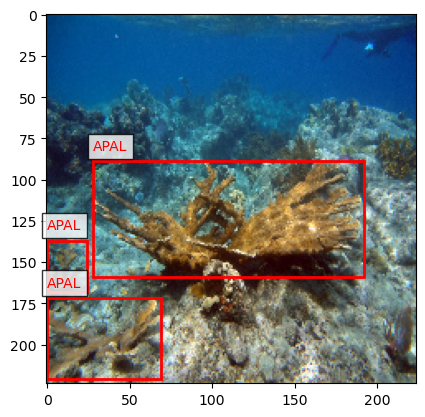

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose an index to visualize
index_to_visualize = 200

# Get the image and label for the chosen index
image_to_visualize = images_array[index_to_visualize]
labels_to_visualize = labels_array[index_to_visualize]

# Define a mapping from numeric class labels to class names
class_label_mapping = {0: 'APAL', 1: 'Pseudodiploria'}

# Display the image
plt.imshow(cv2.cvtColor(image_to_visualize, cv2.COLOR_BGR2RGB))

# Iterate through bounding boxes in YOLO format
for box in labels_to_visualize:
    class_label, center_x, center_y, width, height = box

    # Rescale the coordinates based on the resized image size
    x = int(center_x * resize_width)
    y = int(center_y * resize_height)
    w = int(width * resize_width)
    h = int(height * resize_height)

    # Calculate top-left coordinates
    x_min = max(0, x - w // 2)
    y_min = max(0, y - h // 2)

    # Ensure the bounding box stays within the image bounds
    x_min = min(x_min, resize_width - 1)
    y_min = min(y_min, resize_height - 1)
    w = min(w, resize_width - x_min)
    h = min(h, resize_height - y_min)

    # Create a Rectangle patch
    bbox = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='r', facecolor='none')

    # Add the bbox to the plot
    plt.gca().add_patch(bbox)

    # Map numeric class label to class name
    class_name = class_label_mapping.get(class_label, str(class_label))

    # Add class label to the plot
    plt.text(x_min, y_min - 5, class_name, color='r', verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# Display the plot
plt.show()


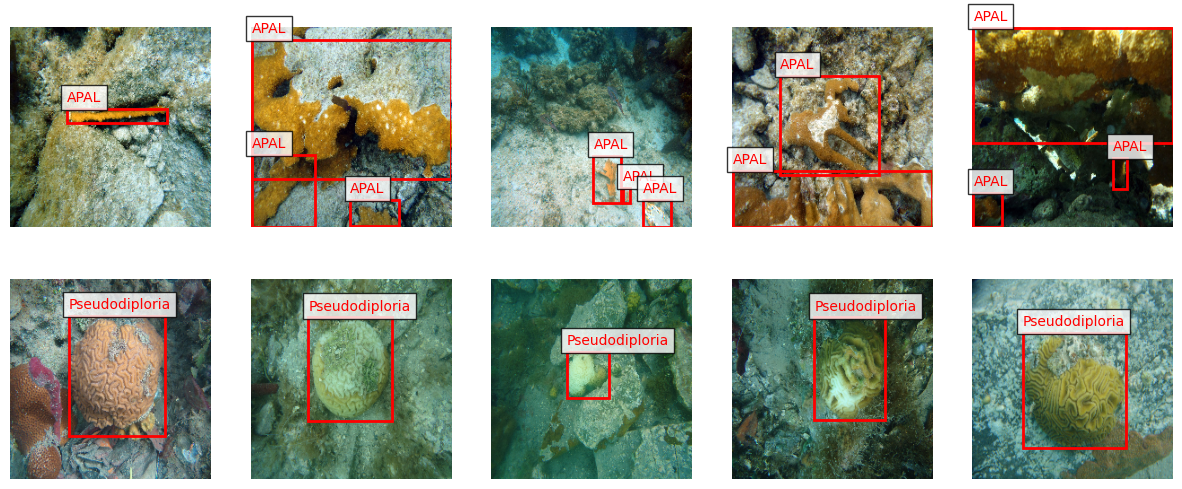

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Choose the classes to visualize
classes_to_visualize = {0: 'APAL', 1: 'Pseudodiploria'}

# Counter to keep track of displayed images for each class
displayed_images_count = {'APAL': 0, 'Pseudodiploria': 0}

# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Iterate through classes to visualize
for class_label, class_name in classes_to_visualize.items():
    # Filter images with the current class
    class_images = [(images_array[i], labels_array[i]) for i, labels in enumerate(labels_array) if any(box[0] == class_label for box in labels)]

    # Randomly select up to 5 images for the current class
    selected_images = random.sample(class_images, min(5, len(class_images)))

    # Display the selected images
    for i, (image, labels) in enumerate(selected_images):
        # Display the image
        axs[class_label * 5 + i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Iterate through bounding boxes and display
        for box in labels:
            if box[0] == class_label:
                center_x, center_y, width, height = box[1:]
                x = int(center_x * resize_width)
                y = int(center_y * resize_height)
                w = int(width * resize_width)
                h = int(height * resize_height)
                x_min = max(0, x - w // 2)
                y_min = max(0, y - h // 2)

                # Display the bounding box
                bbox = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='r', facecolor='none')
                axs[class_label * 5 + i].add_patch(bbox)

                # Display the class label within the bounding box
                axs[class_label * 5 + i].text(x_min, y_min - 5, class_name, color='r', verticalalignment='bottom',
                                              bbox=dict(facecolor='white', alpha=0.8))

        # Remove axis ticks and labels
        axs[class_label * 5 + i].axis('off')

# Show the plot
plt.show()


In [23]:
# Extract unique class labels from all annotations
unique_classes = set()
for labels in labels_array:
    for box in labels:
        unique_classes.add(box[0])

# Print the unique classes
print("Unique Classes:", unique_classes)


Unique Classes: {0, 1}


In [29]:
# Filter images and labels for the '0' class
filtered_images_apal = images_array[
    [any(box[0] == 0 for box in labels) for labels in labels_array]
]
filtered_labels_apal = labels_array[
    [any(box[0] == 0 for box in labels) for labels in labels_array]
]

# Display the shapes
print("Filtered Images shape for class 0:", filtered_images_apal.shape)
print("Filtered Labels shape for class 0:", filtered_labels_apal.shape)


Filtered Images shape for class 0: (116, 224, 224, 3)
Filtered Labels shape for class 0: (116,)


In [31]:
# Save the apal images to a pickle file
with open('images_yolo.pkl', 'wb') as file:
    pickle.dump(filtered_images_apal, file)

    
# Save the apal labels to a pickle file
with open('labels_yolo.pkl', 'wb') as file:
    pickle.dump(filtered_labels_apal, file)


In [32]:
# Define the filenames for the pickle files
images2 = 'augmented_apal_images_yolo.pickle'
labels2 = 'augmented_apal_labels_yolo.pickle'


# Load the augmented images from the pickle file
with open(images2, 'rb') as file:
    images2 = pickle.load(file)

# Load the augmented labels from the pickle file
with open(labels2, 'rb') as file:
    labels2 = pickle.load(file)

print("Loaded Images Shape:", images2.shape)
print("Loaded Labels Shape:", labels2.shape)


Loaded Images Shape: (580, 224, 224, 3)
Loaded Labels Shape: (580,)


In [33]:
# Concatenate the loaded data
images = np.concatenate((images_array, images2), axis=0)
labels = np.concatenate((labels_array, labels2), axis=0)

# Print the shape of the concatenated arrays
print("Concatenated Images Shape:", images.shape)
print("Concatenated Labels Shape:", labels.shape)


Concatenated Images Shape: (1479, 224, 224, 3)
Concatenated Labels Shape: (1479,)


In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (946, 224, 224, 3)
y_train shape: (946,)
X_valid shape: (237, 224, 224, 3)
y_valid shape: (237,)
X_test shape: (296, 224, 224, 3)
y_test shape: (296,)


In [35]:
# Save your data to a pickle file
with open('../data/external/data_yolo.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test, X_valid, y_valid), f)